In [4]:
import sys
!$sys.executable -m pip install tensorflow ##Installing tensorflow

     |████████████████████████████████| 241.2 MB 91 kB/s s eta 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 438 kB 36.7 MB/s eta 0:00:01
  Using cached libclang-14.0.6-py2.py3-none-macosx_10_9_x86_64.whl (13.2 MB)
  Using cached flatbuffers-22.10.26-py2.py3-none-any.whl (26 kB)
  Using cached grpcio-1.50.0-cp38-cp38-macosx_10_10_x86_64.whl (4.5 MB)
     |████████████████████████████████| 5.9 MB 15.8 MB/s eta 0:00:01
  Using cached protobuf-3.19.6-cp38-cp38-macosx_10_9_x86_64.whl (980 kB)
  Using cached termcolor-2.1.0-py3-none-any.whl (5.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_io_gcs_filesystem-0.27.0-cp38-cp38-macosx_10_14_x86_64.whl (1.6 MB)

In [1]:
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np

In [2]:
tf.random.set_seed(3)

In [3]:
file = 'SP500predictive.csv'
raw_data = pd.read_csv(file, parse_dates = ['Date'], index_col = "Date")

df = raw_data.copy()
df = df.iloc[::-1]
df.head()

,ChangeSP500,save.Value,CPI,FederalFundsRate,X10YrTreasuryYield,EconomicPolicyUncertainty,CrudeOilPrice,FederalReserveLoans,FedReservesOnHand,Index,ExpectedStockIncrease,InterestRates
Date,,,,,,,,,,,,
2010-07-31,0.068778,6.4,217.923,0.16,3.42,84.82,20.74,49773,995.183,67.8,44.7,2.357143
2010-08-31,-0.047449,6.5,218.275,0.10,3.47,81.91,24.42,47564,1003.206,68.9,45.4,2.323232
2010-09-30,0.087551,6.5,219.035,0.09,3.32,75.96,26.27,46685,1011.124,68.2,45.2,2.222222
2010-10-31,0.036856,6.3,219.590,0.10,3.05,71.40,27.02,45084,1027.089,67.7,46.4,2.313131
2010-11-30,-0.002290,6.1,220.472,0.07,3.18,128.68,25.52,23259,1078.051,71.6,50.5,2.252525


<AxesSubplot:xlabel='Date'>

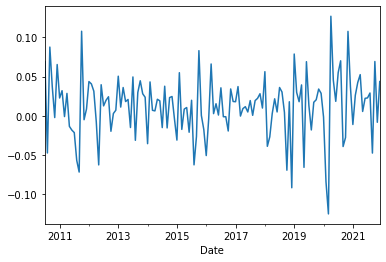

In [5]:
SP500 = df['ChangeSP500']
SP500.plot()

In [8]:
SP500.to_csv('SP500Autocorr.csv')

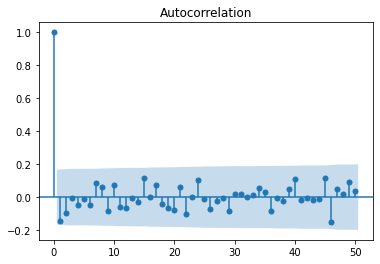

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(SP500, lags = 50)
plt.show()

In [15]:
def dfToXY(df, window_size=5):
    df_as_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        x.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(x), np.array(y)

In [16]:
x,y = dfToXY(df, 4)
x.shape, y.shape

((134, 4, 12), (134,))

In [17]:
x = np.squeeze(x) #getting rid of the third dimension (=value 1) from x array
x.shape

(134, 4, 12)

In [21]:
trainSize = int(len(df)*0.80)
valSize = int(len(df)*.05)
xTrain, yTrain = x[:trainSize], y[:trainSize]
xVal, yVal = x[trainSize:trainSize+valSize], y[trainSize:trainSize+valSize]
xTest, yTest = x[trainSize+valSize:], y[trainSize+valSize:]
xTrain.shape, yTrain.shape, xVal.shape,yVal.shape,xTest.shape, yTest.shape

((110, 4, 12), (110,), (6, 4, 12), (6,), (18, 4, 12), (18,))

In [19]:
SPTrainMean = np.mean(xTrain[:, :, 0])
SPTrainStd = np.std(xTrain[:, :, 0])

#print(SPTrainMean)
#print(SPTrainStd)                   

def preprocess(x):
    x[:, :, 0] = (x[:, :, 0] - SPTrainMean) / SPTrainStd
    return x

In [22]:
preprocess(xTrain)
preprocess(xTest)
preprocess(xVal)

array([[[ 5.80824031e+00,  7.30000000e+00,  2.57305000e+02,
          5.00000000e-02,  6.40000000e-01,  4.40070000e+02,
          1.10040000e+02,  4.00000000e+01,  1.52669700e+03,
          9.32000000e+01,  5.68000000e+01,  2.07142857e+00],
        [ 8.56155977e+00,  7.40000000e+00,  2.57788000e+02,
          5.00000000e-02,  6.50000000e-01,  5.57190000e+02,
          1.01330000e+02,  1.30000000e+01,  1.65192700e+03,
          9.55000000e+01,  5.71000000e+01,  2.19191919e+00],
        [ 2.00940644e+01,  7.50000000e+00,  2.58263000e+02,
          8.00000000e-02,  6.60000000e-01,  2.92370000e+02,
          9.62900000e+01,  3.40000000e+01,  1.61634200e+03,
          9.68000000e+01,  6.10000000e+01,  2.18367347e+00],
        [ 1.54716316e+01,  7.30000000e+00,  2.58682000e+02,
          1.00000000e-01,  5.50000000e-01,  3.84080000e+02,
          9.71900000e+01,  1.30000000e+01,  1.62646900e+03,
          9.93000000e+01,  6.38000000e+01,  2.23711340e+00]],

       [[ 8.56155977e+00,  7.40000

In [23]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [69]:
model1 = Sequential()
model1.add(InputLayer((4, 12)))
model1.add(LSTM(100))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 100)               45200     
                                                                 
 dense_8 (Dense)             (None, 8)                 808       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 46,017
Trainable params: 46,017
Non-trainable params: 0
_________________________________________________________________


In [70]:
cp = ModelCheckpoint("model1/", save_best_only = True, monitor = "loss")
model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate = 0.0001), metrics=[RootMeanSquaredError()])

In [94]:
model1.fit(xTrain,yTrain,validation_data = (xVal,yVal),epochs = 10, callbacks =[cp])

Epoch 1/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0181 - root_mean_squared_error: 0.1347

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0344 - root_mean_squared_error: 0.1854 - val_loss: 0.1837 - val_root_mean_squared_error: 0.4286
Epoch 2/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0461 - root_mean_squared_error: 0.2148

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0299 - root_mean_squared_error: 0.1729 - val_loss: 0.1782 - val_root_mean_squared_error: 0.4221
Epoch 3/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0295 - root_mean_squared_error: 0.1717

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0254 - root_mean_squared_error: 0.1593 - val_loss: 0.1759 - val_root_mean_squared_error: 0.4194
Epoch 4/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.1017

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0219 - root_mean_squared_error: 0.1478 - val_loss: 0.1747 - val_root_mean_squared_error: 0.4180
Epoch 5/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0348 - root_mean_squared_error: 0.1866

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0197 - root_mean_squared_error: 0.1403 - val_loss: 0.1741 - val_root_mean_squared_error: 0.4173
Epoch 6/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0203 - root_mean_squared_error: 0.1426

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 5s 2s/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.1737 - val_root_mean_squared_error: 0.4168
Epoch 7/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0166 - root_mean_squared_error: 0.1288

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0160 - root_mean_squared_error: 0.1265 - val_loss: 0.1733 - val_root_mean_squared_error: 0.4163
Epoch 8/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.1180

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0151 - root_mean_squared_error: 0.1227 - val_loss: 0.1730 - val_root_mean_squared_error: 0.4160
Epoch 9/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.1067

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.1733 - val_root_mean_squared_error: 0.4163
Epoch 10/10
1/4 [======>.......................] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0768

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


4/4 [==============================] - 4s 1s/step - loss: 0.0136 - root_mean_squared_error: 0.1167 - val_loss: 0.1733 - val_root_mean_squared_error: 0.4162


In [95]:
trainPredictions = model1.predict(xTrain).flatten()
trainResults = pd.DataFrame(
    data = {'Train Predictions':trainPredictions,
    "Actuals":yTrain})
trainResults

4/4 [==============================] - 0s 3ms/step


,Train Predictions,Actuals
0,0.063977,-0.002290
1,0.063977,0.065300
2,0.063977,0.022646
3,0.095840,0.031957
4,0.095840,-0.001047
...,...,...
105,-0.121304,-0.018092
106,0.074697,0.017181
107,0.047674,0.020432
108,0.390249,0.034047


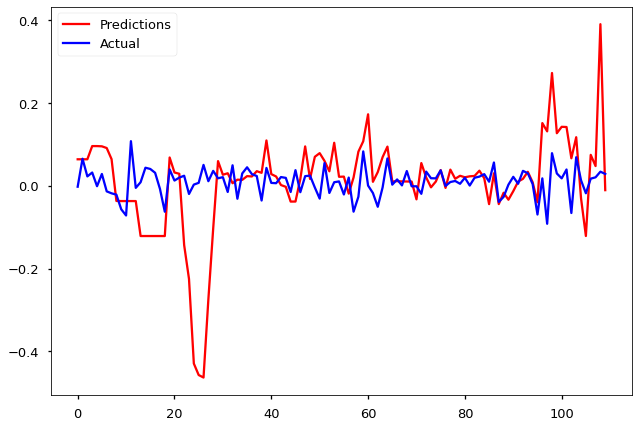

In [109]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
plt.plot(trainResults['Train Predictions'],"-r",label = "Predictions")
plt.plot(trainResults['Actuals'], "-b",label = "Actual Values")

location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [97]:
testPredictions = model1.predict(xTest).flatten()
testResults = pd.DataFrame(
    data = {'Test Predictions':testPredictions,
    "Actuals":yTest})
testResults

1/1 [==============================] - 0s 32ms/step


,Test Predictions,Actuals
0,0.063977,0.055101
1,0.063977,0.070065
2,0.063977,-0.039228
3,0.063977,-0.027666
4,0.063977,0.107546
5,0.116367,0.037121
6,0.063977,-0.011137
7,0.116363,0.026091
8,0.063977,0.042439
9,0.063977,0.052425


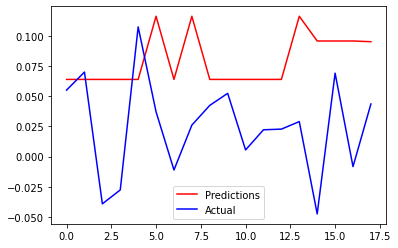

In [98]:
plt.plot(testResults['Test Predictions'], "-r")
plt.plot(testResults['Actuals'],"-b")


location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [76]:
rmse = np.sqrt(np.mean(testPredictions - yTest)**2)
rmse

0.01870776301301914

In [77]:
mae = np.mean(abs(testPredictions - yTest))
mae

0.0389370999991489

In [108]:
rmse = np.sqrt(np.mean(trainPredictions - yTrain)**2)
rmse

0.0012360515844938623

In [107]:
mae = np.mean(abs(trainPredictions - yTrain))
mae

0.07032403852966582

In [78]:
model2 = Sequential()
model2.add(InputLayer((4, 12)))
model2.add(LSTM(100, activation='relu', return_sequences=True))
model2.add(LSTM(100, activation = 'relu', return_sequences = True))
model2.add(LSTM(100))
model2.add(Dropout(0.1))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 4, 100)            45200     
                                                                 
 lstm_13 (LSTM)              (None, 4, 100)            80400     
                                                                 
 lstm_14 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 206,101
Trainable params: 206,101
Non-trainable params: 0
_________________________________________________________________


In [79]:
cp2 = ModelCheckpoint("model2/", save_best_only = True, monitor = "loss")
model2.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate = 0.0001), metrics=[RootMeanSquaredError()])

In [87]:
model2.fit(xTrain,yTrain,validation_data = (xVal,yVal),epochs = 25, callbacks =[cp2])

Epoch 1/25
4/4 [==============================] - 2s 689ms/step - loss: 0.0625 - root_mean_squared_error: 0.2499 - val_loss: 0.0674 - val_root_mean_squared_error: 0.2597
Epoch 2/25
4/4 [==============================] - ETA: 0s - loss: 0.0504 - root_mean_squared_error: 0.2244

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 10s 3s/step - loss: 0.0504 - root_mean_squared_error: 0.2244 - val_loss: 0.0696 - val_root_mean_squared_error: 0.2638
Epoch 3/25
1/4 [======>.......................] - ETA: 0s - loss: 0.0344 - root_mean_squared_error: 0.1856

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.0426 - root_mean_squared_error: 0.2065 - val_loss: 0.0697 - val_root_mean_squared_error: 0.2641
Epoch 4/25
4/4 [==============================] - 0s 24ms/step - loss: 0.0458 - root_mean_squared_error: 0.2140 - val_loss: 0.0965 - val_root_mean_squared_error: 0.3106
Epoch 5/25
4/4 [==============================] - 0s 27ms/step - loss: 0.0583 - root_mean_squared_error: 0.2415 - val_loss: 0.0989 - val_root_mean_squared_error: 0.3144
Epoch 6/25
4/4 [==============================] - 0s 24ms/step - loss: 0.0698 - root_mean_squared_error: 0.2642 - val_loss: 0.0976 - val_root_mean_squared_error: 0.3124
Epoch 7/25
4/4 [==============================] - 0s 23ms/step - loss: 0.0781 - root_mean_squared_error: 0.2794 - val_loss: 0.1049 - val_root_mean_squared_error: 0.3238
Epoch 8/25
4/4 [==============================] - 0s 31ms/step - loss: 0.0572 - root_mean_squared_error: 0.2392 - val_loss: 0.1077 - val_root_mean_squared_error: 0.3282

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


4/4 [==============================] - 7s 2s/step - loss: 0.0409 - root_mean_squared_error: 0.2023 - val_loss: 0.0492 - val_root_mean_squared_error: 0.2217
Epoch 16/25
4/4 [==============================] - 0s 25ms/step - loss: 0.0423 - root_mean_squared_error: 0.2056 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1922
Epoch 17/25
4/4 [==============================] - 0s 28ms/step - loss: 0.0716 - root_mean_squared_error: 0.2676 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1781
Epoch 18/25
4/4 [==============================] - 0s 33ms/step - loss: 0.0571 - root_mean_squared_error: 0.2390 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1784
Epoch 19/25
4/4 [==============================] - 0s 20ms/step - loss: 0.0520 - root_mean_squared_error: 0.2281 - val_loss: 0.0432 - val_root_mean_squared_error: 0.2079
Epoch 20/25
4/4 [==============================] - 0s 20ms/step - loss: 0.0465 - root_mean_squared_error: 0.2156 - val_loss: 0.0440 - val_root_mean_squared_error: 0

In [88]:
trainPredictions2 = model2.predict(xTrain).flatten()
trainResults2 = pd.DataFrame(
    data = {'Train Predictions':trainPredictions2,
    "Actuals":yTrain})
trainResults2

4/4 [==============================] - 0s 6ms/step


,Train Predictions,Actuals
0,0.024163,-0.002290
1,-0.155231,0.065300
2,-0.158129,0.022646
3,-0.090906,0.031957
4,-0.086046,-0.001047
...,...,...
105,0.042707,-0.018092
106,0.175186,0.017181
107,0.047947,0.020432
108,0.029310,0.034047


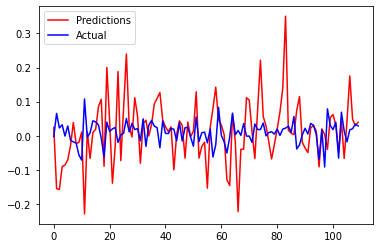

In [89]:
plt.plot(trainResults2['Train Predictions'],"-r",label = "Predictions")
plt.plot(trainResults2['Actuals'], "-b",label = "Actual Values")

location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [90]:
testPredictions2 = model2.predict(xTest).flatten()
testResults2 = pd.DataFrame(
    data = {'Test Predictions':testPredictions2,
    "Actuals":yTest})
testResults2

1/1 [==============================] - 0s 26ms/step


,Test Predictions,Actuals
0,0.024169,0.055101
1,0.024169,0.070065
2,0.024169,-0.039228
3,-0.143468,-0.027666
4,-0.143456,0.107546
5,-0.018151,0.037121
6,-0.152085,-0.011137
7,-0.167711,0.026091
8,0.008827,0.042439
9,0.112351,0.052425


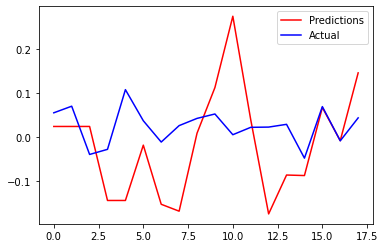

In [91]:
plt.plot(testResults2['Test Predictions'], "-r")
plt.plot(testResults2['Actuals'],"-b")


location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [92]:
rmse = np.sqrt(np.mean(testPredictions2 - yTest)**2)
rmse

0.03940139108388889

In [93]:
mae = np.mean(abs(testPredictions2 - yTest))
mae

0.09618310197520118

In [105]:
trainrmse = np.sqrt(np.mean(trainPredictions2 - yTrain)**2)
trainrmse

0.004412254206999812

In [106]:
trainmae = np.mean(abs(trainPredictions2 - yTrain))
trainmae

0.0677529686052578

In [104]:
from keras.models import load_model
    
model2.save('SP500Model2.h5')  # creates a HDF5 file 'my_model.h5'
model2 = load_model('SP500Model2.h5')# returns a compiled model identical to the previous one

In [99]:
raw_data = pd.read_csv(file,parse_dates = ["Date"], index_col = False)
df1 = raw_data.copy()

Dates = df1.iloc[::-1]
Dates = Dates["Date"]
Dates.head()

137   2010-07-31
136   2010-08-31
135   2010-09-30
134   2010-10-31
133   2010-11-30
Name: Date, dtype: datetime64[ns]

In [100]:
trainSize = int(len(Dates)*0.80)
valSize = int(len(Dates)*.05)

trainDates = Dates[:trainSize]
testDates = Dates[trainSize+valSize:]

In [101]:
trainDates = Dates[0:109]
testDates = Dates[120:138]

trainDates = trainDates.reset_index()
testDates = testDates.reset_index()

trainDates = trainDates.pop('Date')
testDates = testDates.pop('Date')

#trainDates
#testDates

In [117]:
trainResults = pd.concat([trainResults,trainDates],axis=1)
testResults = pd.concat([testResults,testDates],axis=1)

trainResults = trainResults.set_index("Date")
testResults = testResults.set_index("Date")


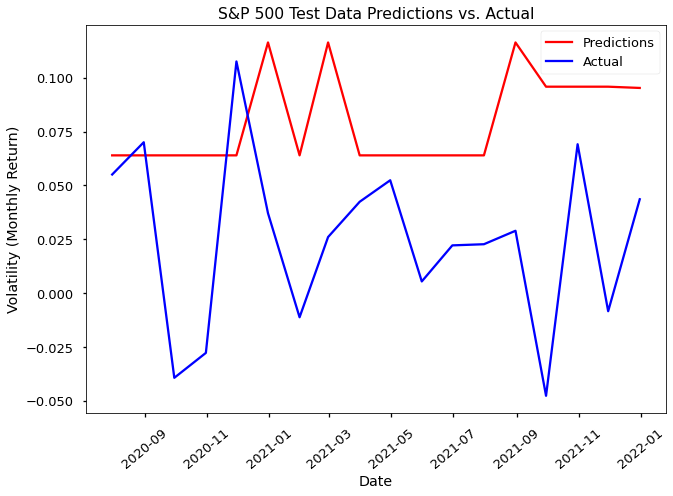

In [118]:
plt.plot(testResults['Test Predictions'], "-r")
plt.plot(testResults['Actuals'],"-b")
plt.xticks(rotation = 40) # 40 is the rotation angle
plt.title("S&P 500 Test Data Predictions vs. Actual")
plt.xlabel('Date') 
plt.ylabel('Volatility (Monthly Return)') 
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

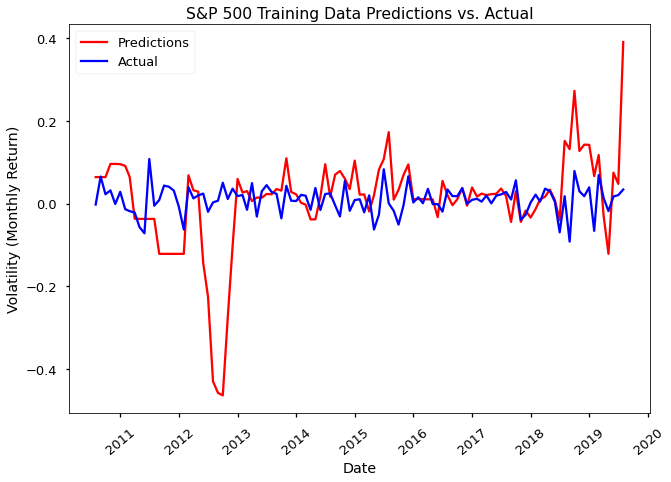

In [119]:
plt.plot(trainResults['Train Predictions'], "-r")
plt.plot(trainResults['Actuals'],"-b")
plt.xticks(rotation = 40) # 40 is the rotation angle
plt.title("S&P 500 Training Data Predictions vs. Actual")
plt.xlabel('Date') 
plt.ylabel('Volatility (Monthly Return)') 
location = 0 # For the best location
legend_drawn_flag = True
plt.legend(["Predictions", "Actual"], loc=0, frameon=legend_drawn_flag)

In [121]:
trainResults.to_csv('SPTrainResults.csv')
testResults.to_csv('SPTestResults.csv')